In [1]:
#####
#preliminary functions
#####

using Printf
using Plots
using LinearAlgebra

######
#WA mc routine

const L       = 10             # linear size of lattice
const temps   = 1.2:-0.2:0.1  # temperatures to sample
const nt = length(temps)      #number of temperatures
#the 4 different bond directions on the lattice
dir_list = [[1,0,1], [0,1,1], [-1,0,-1], [0,-1,-1]] 
#index 1,2 is the direction in x,y 
#index 3 is the default link value in that direction
#link_default = [1,1,-1,-1]



#these arrays allow us to selct the x or y direction bonds
all_x = ones(Int32, 2*L, 2*L)
all_y = ones(Int32, 2*L, 2*L)

for i in 1:2:2*L
    all_x[:,i] = zeros(Int32, 2*L)
    all_y[i,:] = zeros(Int32, 2*L)
end

In [2]:
function sweep(nv, ratio, all_map) 
    
    i = 0
    #winding = 0.0
    worm_num = 0
    #energy = 0.0
    kappa = 1.0

    while i <= nv
        #pick a I = M site
        worm_num += 1
        Ix = 2*rand(1:L)
        Iy = 2*rand(1:L)
        Mx = Ix
        My = Iy
        cond = true
        wind_x = 0.0
        wind_y = 0.0
        count_this_worm = 0
        while cond
            #choose a bond direction
            dir_link = dir_list[rand(1:4)]
            link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
            link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
            link_val = all_map[link_x, link_y] #that's the current value there
            prop_add = dir_link[3]
            
            new_val = link_val + prop_add
            #test_prop = (absolute(new_val) < 2) #truncate updates
            #if test_prop
            
            deltaS = (ratio)*(new_val^2 - link_val^2) 
            #random number and acceptance test
            p = rand()
            barrier = minimum([1, kappa*exp(-deltaS)])
            if (p < barrier)
                all_map[link_x, link_y] = new_val
                Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
                My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
                i += 1   
                #wind_x += dir_link[1]     
                #wind_y += dir_link[2]

            end

            cond = !(Ix == Mx && Iy == My)
            #print(" ", cond, "\n")
        end
        
        
        #winding += 0.5*(sum(all_map.*all_x)/L)^2 + (sum(all_map.*all_y)/L)^2
        #energy += (ratio)*(sum(all_map)/L)^2
            
    end
    
    display([worm_num, nv])
    
    #return winding/worm_num, energy/worm_num
end

#testing
#all_map_test = sweep(10, 0.9, zeros(Int32,2*10,2*10))
#it is nonzero = it works

function measureWorm(ratio, all_map, g_maps_temperature)
    #pick a I = M site
    Ix = 2*rand(1:L)
    Iy = 2*rand(1:L)
    Mx = Ix
    My = Iy
    cond = true
    w_l = 0
    dist_M_to_I = [0,0] 
    g_map_temp = zeros(Int32, L, L) 
    
    while cond
        #choose a bond direction
        dir_link = dir_list[rand(1:4)]
        link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
        link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
        link_val = all_map[link_x, link_y] #that's the current value there
        prop_add = dir_link[3]

        new_val = link_val + prop_add
        #test_prop = (absolute(new_val) < 2) #truncate updates
        #if test_prop

        deltaS = (ratio)*(new_val^2 - link_val^2) 
        #random number and acceptance test
        p = rand()
        barrier = minimum([1, exp(-deltaS)])
        if (p < barrier)
            all_map[link_x, link_y] = new_val
            Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
            My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
            w_l += 1
            #correlation map
            dist_M_to_I += dir_link[1:2]
            g_x = 1 + mod(dist_M_to_I[1], L)
            g_y = 1 + mod(dist_M_to_I[2], L)
            g_map_temp[g_x, g_y] += 1
            #count_this_worm += 1

            #display("accept")
        end

        cond = !(Ix == Mx && Iy == My)
        #print(" ", cond, "\n")
    end

    winding = ((sum(all_map.*all_x)/L)^2 + (sum(all_map.*all_y)/L)^2)
    energy = (g_map_temp[1,2] + g_map_temp[2,1]+ g_map_temp[1,L] + g_map_temp[L,1])/(2)
    magsq = sum(g_map_temp)
    
    g_maps_temperature += g_map_temp
    #energy = (ratio)*(sum(all_map)/L)^2
    #display([w_l, nv])
    
    return winding, energy, w_l, magsq
end

measureWorm (generic function with 1 method)

In [5]:
######
#WA mc routine for the XY 


n_sweep = L^2             # number of sweeps between sampling
n_therm = 1000*L^2           # number of sweeps to thermalize
n_data  = 10000*L^2          # number of data samples per temperature

#empty lists of measures to fill
et = []                  # array to append average energy at each T
magt = []                 # "                      magnetization squared
cv = []                 # "                      specific heat
rho = []               # "                      winding numbers = stiffness
rho_err = []               # "                      winding numbers = stiffness
#store the correlation function G(I - M) for all temperatures
g_maps = zeros(Int32, L, L, nt)

#initialize the configuration - double the number of indices, bonds live on even indices
all_map = zeros(Int32,2*L, 2*L) 

all_stiff_t = zeros(Float64, n_data, nt)


for ti in 1:nt              # loop over temperatures
    T = temps[ti]
    β = 1/T
    ratio = 1/(β)
    
    bonds_list = zeros(Float64, n_data)
    ene_list = zeros(Float64, n_data)
    mag_list = zeros(Float64, n_data)
    stiff_list = zeros(Float64, n_data)
    g_maps_temperature = zeros(Int32, L, L)
    
    #initialize the starting configuration as either the zero-filled one
    #or the last map obtained after the measurements from the previous high-temperature
    sweep(n_therm, ratio, all_map)    # thermalize the lattice
    m = 0
    n_data_r = 1
    #this loop does *at least* at most n_data worms.
    #when worms are very long (low-T), it does less - in essence, n_data/L^2 updates
    while m < n_data
        #sweep(n_sweep, ratio, all_map)        
        wave, ene, worm_length, mag2 = measureWorm(ratio, all_map, g_maps_temperature)  #to add - green's functions
        if worm_length != 0
            m += worm_length
            #g_maps_temperature += g_meas
            ene_list[n_data_r] = ene
            mag_list[n_data_r] = mag2
            
            #ene_list[n_data_r] = -ene
            stiff_list[n_data_r] = T*wave   
            n_data_r += 1
        end
    end    
    
    display(stiff_list[100:300])
    
    #winding, energy = sweep(n_data, ratio, all_map)    # thermalize the lattice
    #push!(et, energy)
    #push!(all_wind, T*winding)
    #display(n_data_r)
    
    #all_stiff_t[:,ti] = stiff_list
    en_ave = sum(ene_list)/n_data_r
    cv_ave = sqrt(sum((ene_list .- en_ave).^2) / (n_data_r - 1))
    mag_ave = sum(mag_list)/n_data_r
    stiff_ave = sum(stiff_list)/n_data_r
    stiff_err = sqrt(sum((stiff_list .- stiff_ave).^2) / (n_data_r - 1))
    push!(et,-en_ave)                # add to the list    
    push!(cv, cv_ave)                # add to the list
    push!(magt, mag_ave)                # add to the list
    push!(rho, stiff_ave)
    push!(rho_err, stiff_ave)
    
    @printf("T = %8.3f  stiff = %8.3f E = %8.3f \n", T, stiff_ave, -en_ave)
    flush(stdout)
end

2-element Vector{Int64}:
  28996
 100000

T =    1.200  stiff =    0.015 E =   -1.116 


2-element Vector{Int64}:
   9349
 100000

T =    1.000  stiff =    0.173 E =   -1.340 


2-element Vector{Int64}:
   4001
 100000

T =    0.800  stiff =    0.760 E =   -1.614 


2-element Vector{Int64}:
   2295
 100000

T =    0.600  stiff =    0.998 E =   -1.749 


2-element Vector{Int64}:
   1871
 100000

T =    0.400  stiff =    1.021 E =   -1.865 


2-element Vector{Int64}:
   1426
 100000

T =    0.200  stiff =    1.029 E =   -1.876 


In [6]:
stiff_list

LoadError: UndefVarError: stiff_list not defined

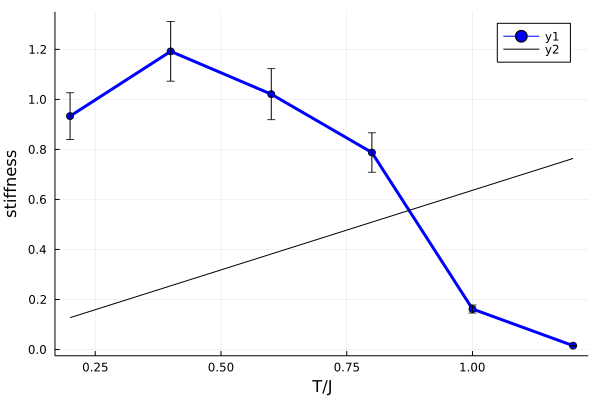

In [4]:
#temps = temps[end:-1:1]
#all_wind = all_wind[end:-1:1]
plot(temps, rho, yerr = rho_err/L, lw = 3, shape = :circle, color = :blue, markersize = 4)
plot!(temps, 2*temps/pi, lw = 1, color = :black)
xlabel!("T/J")
ylabel!("stiffness")

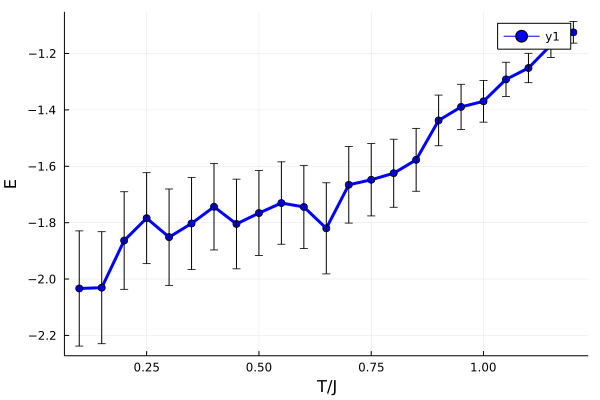

In [27]:
plot(temps, et, yerr = cv/L^2, lw = 3, shape = :circle, color = :blue, markersize = 4)
xlabel!("T/J")
ylabel!("E")

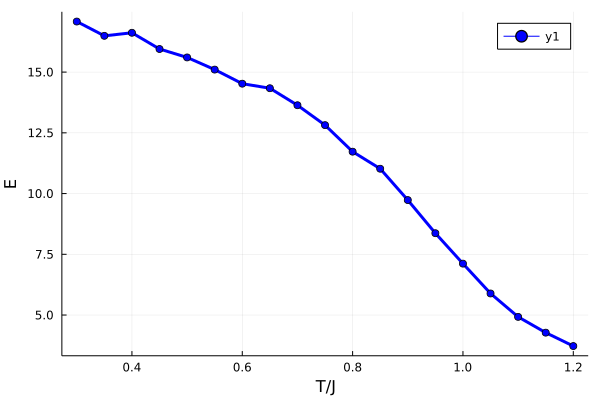

In [7]:
plot(temps, cv, lw = 3, shape = :circle, color = :blue, markersize = 4)
xlabel!("T/J")
ylabel!("E")

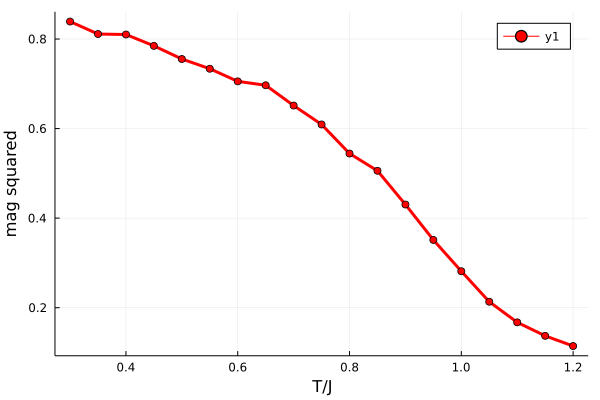

In [9]:
plot(temps, magt/L^2, lw = 3, shape = :circle, color = :red, markersize = 4)
xlabel!("T/J")
ylabel!("mag squared")